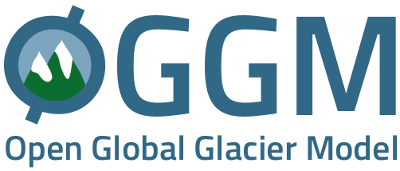

# Getting started with OGGM: a real case study, step by step

The OGGM workflow is best explained with an example. In the following, we will show how to apply the standard [OGGM workflow](http://docs.oggm.org/en/stable/introduction.html) to a list of glaciers. This example is meant to guide you through a first-time setup step-by-step. If you prefer not to install OGGM on your computer, you can always run this notebook in [OGGM-Edu](https://edu.oggm.org) instead!

## Set-up 

### Input data folders

**On your computer only**: before you start, make sure that you have set-up the [input data configuration file](https://docs.oggm.org/en/stable/input-data.html) at your wish.

In the course of this tutorial, we will need to download data needed for each glacier (a couple of mb at max, depending on the chosen glaciers), so make sure you have an internet connection.

### cfg.initialize() and cfg.PARAMS 

An OGGM simulation script will always start with the following commands:

In [1]:
from oggm import cfg, utils
cfg.initialize(logging_level='WORKFLOW')

2019-06-14 15:19:47: oggm.cfg: Using configuration file: C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\params.cfg


A call to [cfg.initialize()](https://docs.oggm.org/en/latest/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some example of these parameters:

In [2]:
cfg.PARAMS['prcp_scaling_factor'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']

(2.5, 900.0, False)

See [here](https://github.com/OGGM/oggm/blob/master/oggm/params.cfg) for the default parameter file and a description of their role and default value.

## Workflow

In [3]:
from oggm import workflow

### Working directory 

Each OGGM run needs a folder to store the results of the computations for all glaciers. This is called a "working directory" and needs to be specified before each run. Here we create a temporary folder for you:

In [4]:
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-GettingStarted', reset=True)
cfg.PATHS['working_dir']

'C:\\Users\\Daniel\\AppData\\Local\\Temp\\OGGM\\OGGM-GettingStarted'

### Define the glaciers for the run 

In [5]:
rgi_ids = ['RGI60-11.01328', 'RGI60-11.00897']

You can provide any number of glacier identifiers to OGGM. Here is a list of other glaciers you might want to try out:

- `RGI60-11.01328`: [Unteraar Glacier](https://en.wikipedia.org/wiki/Unteraargletscher) in the Swiss Alps
- `RGI60-11.00897`: [Hintereisferner](http://acinn.uibk.ac.at/research/ice-and-climate/projects/hintereisferner) in the Austrian Alps. You can also try out:
- `RGI60-18.02342`: Tasman Glacier in New Zealand
- `RGI60-11.00787`: [Kesselwandferner](https://de.wikipedia.org/wiki/Kesselwandferner) in the Austrian Alps
- ... or any other glacier identifier! You can find other glacier identifiers by exploring the [GLIMS viewer](https://www.glims.org/maps/glims).

For an operational run on an RGI region, you might want to download the [Randolph Glacier Inventory](https://www.glims.org/RGI/) dataset and start a run from it. This case is covered in the [OGGM documentation](https://docs.oggm.org/en/latest/run.html) and the [working with the RGI](working_with_rgi.ipynb) tutorial.

### Glacier directories 

The OGGM workflow is organized as a list of **tasks** that have to be applied to a list of glaciers. The vast majority of tasks are called **entity tasks**: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially: they often need input generated by the previous task(s): for example, the climate calibration needs the glacier flowlines, which can be only computed from the topography data.

To handle this complex situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue.

These glacier specific data are located in [glacier directories](https://docs.oggm.org/en/latest/glacierdir.html#glacier-directories). In the model, these directories are initialized with the following command (this can take a little while on the first call, as OGGM needs to download some data):

In [7]:
gdirs = workflow.init_glacier_regions(rgi_ids, from_prepro_level=2, prepro_border=80)

2019-06-14 15:21:49: oggm.workflow: init_glacier_regions from prepro level 2 on 2 glaciers.
2019-06-14 15:21:49: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers


The "border" parameter decides on the number of DEM grid points we'd like to add to each side of the glacier for the local map: the larger the glacier will grow, the larger the border parameter should be. Here we will use [pre-processed directories](https://docs.oggm.org/en/latest/input-data.html#pre-processed-directories), therefore the available border values are: **10, 80, 160, 250.**

The [init_glacier_regions](https://docs.oggm.org/en/latest/generated/oggm.workflow.init_glacier_regions.html#oggm.workflow.init_glacier_regions) task will be the very first task to call for all your OGGM experiments. Let's see what it gives us back:

In [8]:
type(gdirs)

list

`gdirs` is a list of [GlacierDirectory](https://docs.oggm.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects (one for each glacier). These objects are used by the model as "file and attribute manager" for single glaciers. For example, OGGM now knows where to get the topography data for this glacier:

In [9]:
gdir = gdirs[0]  # take Unteraar
print('Path to the DEM:', gdir.get_filepath('dem'))

Path to the DEM: C:\Users\Daniel\AppData\Local\Temp\OGGM\OGGM-GettingStarted\per_glacier\RGI60-11\RGI60-11.01\RGI60-11.01328\dem.tif


And we can also access some attributes of this glacier:

In [10]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.01328
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 23.825 km2
  Lon, Lat: (8.2193, 46.5642)
  Grid (nx, ny): (299, 274)
  Grid (dx, dy): (78.0, -78.0)

In [11]:
gdir.rgi_date  # date at which the outlines are valid

2003

The advantage of this data model is that it can obtain several input data by just using one single argument. For example: both the glacier's location and outlines are needed for the next plot, and the plot function will obtain them from one single argument: `gdir`:

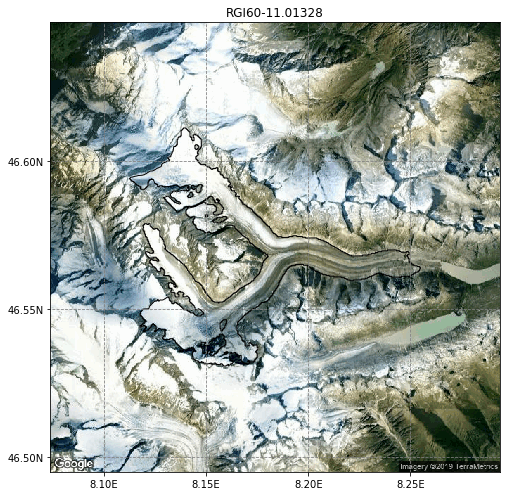

In [12]:
from oggm import graphics
graphics.plot_googlemap(gdir, figsize=(8, 7))

### Tasks

There are two different types of "[tasks](http://docs.oggm.org/en/latest/api.html#entity-tasks)":

**Entity Tasks**:
  Standalone operations to be realized on one single glacier entity,
  independently from the others. The majority of OGGM
  tasks are entity tasks. They are parallelisable: the same task can run on 
  several glaciers in parallel.

**Global Task**:
  Tasks which require to work on several glacier entities
  at the same time. Model parameter calibration or the 
  compilation of several glaciers' output are examples
  of global tasks. They are not parallelisable.
  
OGGM implements a simple mechanism to run a specific task on a list of `GlacierDirectory` objects:

In [13]:
from oggm import tasks

In [14]:
# run the glacier_masks task on all gdirs
workflow.execute_entity_task(tasks.glacier_masks, gdirs);

2019-06-14 15:22:11: oggm.workflow: Execute entity task glacier_masks on 2 glaciers


The task we just applied to our list of glaciers is [glacier_masks](http://docs.oggm.org/en/latest/generated/oggm.tasks.glacier_masks.html#oggm.tasks.glacier_masks). It wrote a new file in our glacier directory, providing raster masks of the glacier (among other things): 

In [15]:
print('Path to the masks:', gdir.get_filepath('gridded_data'))

Path to the masks: C:\Users\Daniel\AppData\Local\Temp\OGGM\OGGM-GettingStarted\per_glacier\RGI60-11\RGI60-11.01\RGI60-11.01328\gridded_data.nc


It is also possible to apply several tasks sequentially (i.e. one after an other) on our glacier list:

In [16]:
list_talks = [
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.compute_downstream_line,
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2019-06-14 15:22:15: oggm.workflow: Execute entity task compute_centerlines on 2 glaciers
2019-06-14 15:22:15: oggm.workflow: Execute entity task initialize_flowlines on 2 glaciers
2019-06-14 15:22:16: oggm.workflow: Execute entity task compute_downstream_line on 2 glaciers


The function `execute_task` can run a task on different glaciers at the same time, if the `use_multiprocessing` option is set to `True` in the configuration file. 

Among other things, we computed the glacier flowlines and the glacier downstream line. We can now plot them:

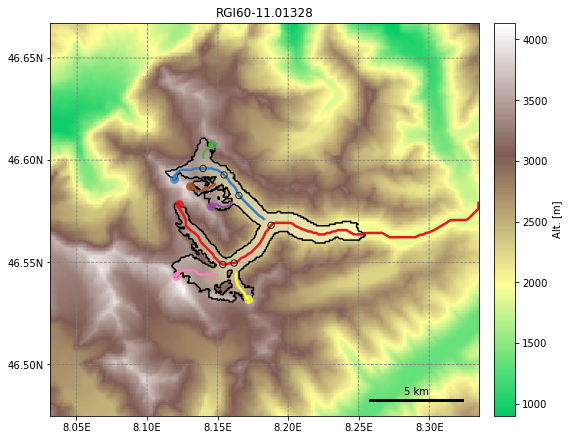

In [17]:
graphics.plot_centerlines(gdir, figsize=(8, 7), use_flowlines=True, add_downstream=True)

The glacier directories now have many more files in them. If you are interested, you can have a look at them:

In [18]:
import os
print(os.listdir(gdir.dir))

['centerlines.pkl', 'climate_info.pkl', 'climate_monthly.nc', 'dem.tif', 'dem_source.txt', 'diagnostics.json', 'downstream_line.pkl', 'geometries.pkl', 'glacier_grid.json', 'gridded_data.nc', 'intersects.tar.gz', 'inversion_flowlines.pkl', 'log.txt', 'outlines.tar.gz', 'outlines.tar.gz.properties']


For a short explanation of what these files are, see the [glacier directory documentation](https://docs.oggm.org/en/latest/glacierdir.html#cfg-basenames). In practice, however, you should not need to read these files yourself.

### Other preprocessing tasks 

Let's continue with the other preprocessing tasks: 

In [19]:
list_talks = [
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2019-06-14 15:22:23: oggm.workflow: Execute entity task catchment_area on 2 glaciers
2019-06-14 15:22:26: oggm.workflow: Execute entity task catchment_width_geom on 2 glaciers
2019-06-14 15:22:27: oggm.workflow: Execute entity task catchment_width_correction on 2 glaciers
2019-06-14 15:22:27: oggm.workflow: Execute entity task compute_downstream_bedshape on 2 glaciers


We just computed the catchment areas of each flowline (colors are arbitrary):

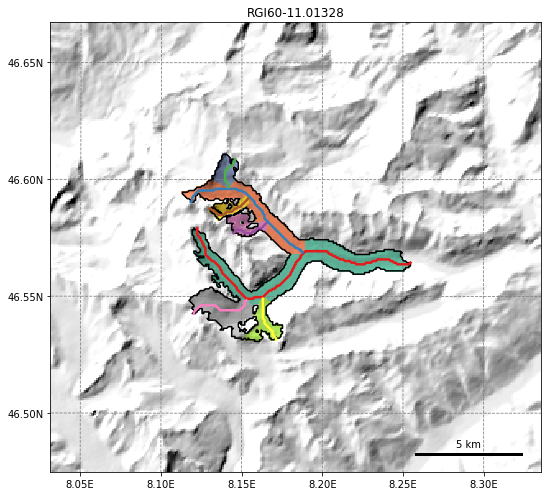

In [20]:
graphics.plot_catchment_areas(gdir, figsize=(8, 7))

Each flowline now knows what area will contribute to its surface mass-balance and ice flow. Accordingly, it is possible to compute each glacier cross-section's width, and correct it so that the total glacier area and elevation distribution is conserved: 

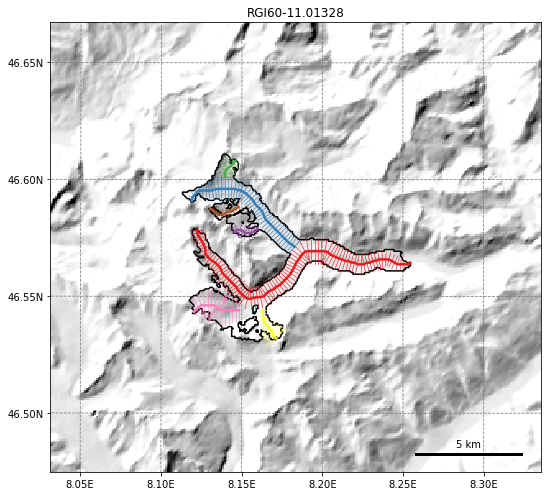

In [21]:
graphics.plot_catchment_width(gdir, corrected=True, figsize=(8, 7))

### Climate tasks 

The glacier directories we downloaded already contains the climate timeseries for each glacier. Let's have a look at them:

C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


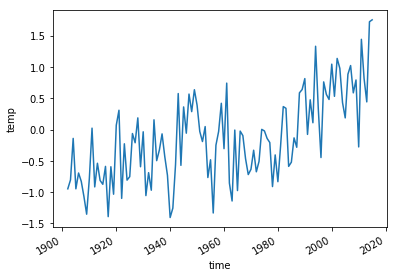

In [22]:
import xarray as xr
fpath = gdir.get_filepath('climate_monthly')
ds = xr.open_dataset(fpath)
# Data is in hydrological years
# -> let's just ignore the first and last calendar years
ds.temp.resample(time='AS').mean()[1:-1].plot();

This climate data is called the "baseline climate" for this glacier. It will be used for the mass-balance model calibration, and at the end of this tutorial also to generate the random climate to drive a simulation. When running OGGM with GCM data, the GCM timeseries will be computed as anomalies to this baseline timeseries, hence the name.

Now, let's calibrate the mass-balance model for this glacier. The calibration procedure of OGGM is ... original, but is very powerful. Read the [doc page](https://docs.oggm.org/en/latest/mass-balance.html) or the [GMD paper](https://www.geosci-model-dev-discuss.net/gmd-2018-9/) for more details.

The whole process is automated:

In [23]:
workflow.execute_entity_task(tasks.local_t_star, gdirs);
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2019-06-14 15:22:39: oggm.workflow: Execute entity task local_t_star on 2 glaciers
2019-06-14 15:22:39: oggm.workflow: Execute entity task mu_star_calibration on 2 glaciers


From there, OGGM can now compute the mass-balance for these two glaciers. For example:

In [24]:
from oggm.core.massbalance import MultipleFlowlineMassBalance
gdir_hef = gdirs[1]
mbmod = MultipleFlowlineMassBalance(gdir_hef, use_inversion_flowlines=True)

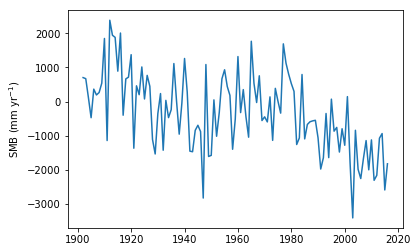

In [25]:
import numpy as np
import matplotlib.pyplot as plt
years = np.arange(1902, 2017)
mb_ts = mbmod.get_specific_mb(year=years)
plt.plot(years, mb_ts); plt.ylabel('SMB (mm yr$^{-1}$)');

For the Hintereiferner (not for Unteraar), we can also compare our computed mass-balance to the measured one:

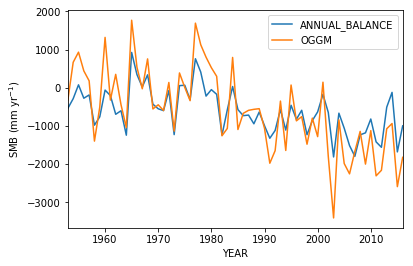

In [26]:
mbdf = gdir_hef.get_ref_mb_data()
mbdf['OGGM'] = mbmod.get_specific_mb(year=mbdf.index)
mbdf[['ANNUAL_BALANCE', 'OGGM']].plot(); plt.ylabel('SMB (mm yr$^{-1}$)');

This graphic is interesting because it shows an effect often observed when comparing the computed mass balance to the observed one: since (in this case) the OGGM geometry is fixed with time, the modelled specific mass-balance series are likely to have a stronger trend than the observed ones.

To assess the results of the OGGM mass-balance model for all 250 WGMS glaciers worldwide, visit our continuously updated [cross-validation](https://cluster.klima.uni-bremen.de/~github/crossval/) page. There you can also see the "blind model" results, i.e. without specific tuning for the glacier considered.

### Computing the ice thickness (Inversion)

With the computed mass-balance and the flowlines, OGGM can now compute the ice thickness, based on the principles [mass conservation and ice dynamics](http://docs.oggm.org/en/latest/inversion.html). 

In [27]:
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

2019-06-14 15:22:45: oggm.workflow: Execute entity task prepare_for_inversion on 2 glaciers
2019-06-14 15:22:45: oggm.workflow: Execute entity task mass_conservation_inversion on 2 glaciers
2019-06-14 15:22:45: oggm.workflow: Execute entity task filter_inversion_output on 2 glaciers


The ice thickness is computed for all sections along the flowline, and can be displayed with the help of OGGM's graphics module:

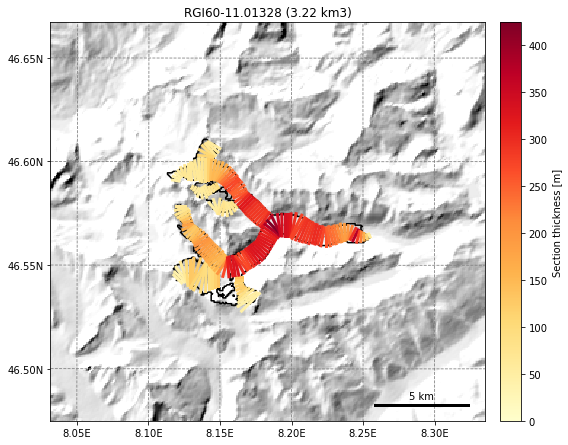

In [28]:
graphics.plot_inversion(gdir, figsize=(8, 7))

The inversion is realized with the default parameter settings: it must be noted that the model is sensitive to the choice of some of them, most notably the creep parameter A:

In [29]:
cfg.PARAMS['inversion_glen_a']

2.4e-24

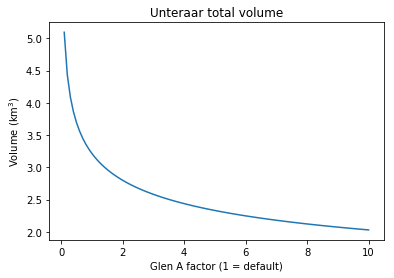

In [30]:
a_factor = np.linspace(0.1, 10., 100)
volume = []
for f in a_factor:
    v, _ = tasks.mass_conservation_inversion(gdir, glen_a=f * cfg.PARAMS['inversion_glen_a'], write=False)
    volume.append(v * 1e-9)
plt.plot(a_factor, volume); plt.title('Unteraar total volume');
plt.ylabel('Volume (km$^3$)'); plt.xlabel('Glen A factor (1 = default)'); 

There is no simple way to find the best A for each individual glacier. It can easily vary of a factor 10 (or more) from one glacier to another. At the global scale, the "best" A is close to the default value (possibly sligthly larger), which makes the default parameter a good choice in a first step.

## Simulations 

For most applications, this is where the fun starts! With climate data and an estimate of the ice thickness, we can now start transient simulations. For this tutorial, we will show how to realize idealized experiments based on the baseline climate only, but it is also possible to drive OGGM with real GCM data as well.

In [31]:
# Convert the flowlines to a "glacier" for the ice dynamics module
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2019-06-14 15:22:49: oggm.workflow: Execute entity task init_present_time_glacier on 2 glaciers


Let's start a run driven by a the climate of the last 31 years, shuffled randomly for 200 years. This can be seen as a "commitment" simulation, i.e. how much glaciers will change even without further climate change:

In [ ]:
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=200,
                             y0=2000, output_filesuffix='_2000');

2019-06-14 15:22:50: oggm.workflow: Execute entity task run_random_climate on 2 glaciers


The output of this simulation is stored in two separate files: a diagnostic file (which contains time series variables such as length, volume, ELA, etc.) and a full model output file, which is larger but allows to reproduce the full glacier geometry changes during the run.

In practice, the diagnostic files are often compiled for the entire lists of glaciers:

In [ ]:
ds2000 = utils.compile_run_output(gdirs, filesuffix='_2000')

This dataset is also stored on disk (in the working directory) as NetCDF file for later use. Here we can access it directly:

In [ ]:
ds2000

We opened the file with [xarray](http://xarray.pydata.org), a very useful data analysis library based on [pandas](http://pandas.pydata.org/). For example, we can plot the volume and length evolution of both glaciers with time:

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ds2000.volume.plot.line(ax=ax1, hue='rgi_id');
ds2000.length.plot.line(ax=ax2, hue='rgi_id');

The full model output files can be used for plots:

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
graphics.plot_modeloutput_map(gdir, filesuffix='_2000', modelyr=0, ax=ax1, vmax=350)
graphics.plot_modeloutput_map(gdir, filesuffix='_2000', modelyr=50, ax=ax2, vmax=350)
graphics.plot_modeloutput_map(gdir, filesuffix='_2000', modelyr=150, ax=ax3, vmax=350)
plt.tight_layout();

### Sensitivity to temperature 

Now repeat our simulations with a +0.5°C and -0.5°C temperature bias, which for a glacier is quite a lot!

In [ ]:
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=200,
                             temperature_bias=0.5,
                             y0=2000, output_filesuffix='_p05');
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=200,
                             temperature_bias=-0.5,
                             y0=2000, output_filesuffix='_m05');

In [ ]:
dsp = utils.compile_run_output(gdirs, filesuffix='_p05')
dsm = utils.compile_run_output(gdirs, filesuffix='_m05')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
rgi_id = 'RGI60-11.01328'
ds2000.sel(rgi_id=rgi_id).volume.plot.line(ax=ax1, hue='rgi_id', label='Commitment');
ds2000.sel(rgi_id=rgi_id).length.plot.line(ax=ax2, hue='rgi_id');
dsp.sel(rgi_id=rgi_id).volume.plot.line(ax=ax1, hue='rgi_id', label='+0.5°C');
dsp.sel(rgi_id=rgi_id).length.plot.line(ax=ax2, hue='rgi_id');
dsm.sel(rgi_id=rgi_id).volume.plot.line(ax=ax1, hue='rgi_id', label='-0.5°C');
dsm.sel(rgi_id=rgi_id).length.plot.line(ax=ax2, hue='rgi_id');
ax1.legend();

From this experiment, we learn that a climate 0.5° would barely be enough to maintain the Unteraar glacier in its preent geometry. 

## What's next?

You have several options from here:
- return to the [OGGM documentation](https://docs.oggm.org), in particular [how to set up an OGGM run](https://docs.oggm.org/en/latest/run.html)
- back to the [table of contents](welcome.ipynb).
- explore other tutorials on the [OGGM-Edu](https://edu.oggm.org) platform.